In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import os
from src import config
from sklearn.model_selection import GridSearchCV

In [2]:
features_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "norm_mem_features_df.pkl"))
labels_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "norm_mem_labels_df.pkl"))

In [3]:
# Remove all the features that are not contains 'Pre' in their name
features_df = features_df.loc[:, ~features_df.columns.str.contains('Post')]

# Remove all the features that are contains 'Saccades' in their name
# features_df = features_df.loc[:, features_df.columns.str.contains('Saccades') | features_df.columns.str.contains(config.MOVIE)]

# # Remove all the features that are not contains 'DVA' in their name
# features_df = features_df.loc[:, features_df.columns.str.contains('DVA') | features_df.columns.str.contains(config.MOVIE)]

features_df.head()

,Movie,Blinks_Per_Minute,Blinks_Duration_Mean,Blinks_Duration_Median,Blink_Variability,Blinks_Duration_Min,Blinks_Duration_Max,Fixations_Count,Fixations_Rate,Fixations_Duration_Mean,...,DVA_Min_Gaze_Pre,DVA_Sem_Gaze_Pre,DVA_AUC_Gaze_Pre,DVA_Mean_Fixations_Pre,DVA_Median_Fixations_Pre,DVA_Std_Fixations_Pre,DVA_Max_Fixations_Pre,DVA_Min_Fixations_Pre,DVA_Sem_Fixations_Pre,DVA_AUC_Fixations_Pre
0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,31.595092,109.756098,109.756098,NaN,100.0,119.512195,-13.157895,-13.157895,17.509492,...,-18.62486,4.477037,-43.02719,-41.479568,-37.662827,7.157519,-0.674697,-56.498126,5.828147,-47.981839


EDA

In [4]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242 entries, 0 to 2241
Columns: 103 entries, Movie to DVA_AUC_Fixations_Pre
dtypes: float64(102), int8(1)
memory usage: 1.7 MB


In [5]:
labels_df.head()

,mem
series_id,
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


In [6]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2242 entries, 0 to 2241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mem     2242 non-null   float64
dtypes: float64(1)
memory usage: 35.0 KB


<AxesSubplot:>

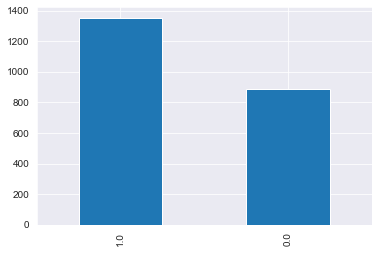

In [7]:
labels_df['mem'].value_counts().plot(kind='bar')

Data Cleaning

how many missing values / inf values are there in each column? show the top 10

In [8]:
features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=0).sort_values(ascending=False).head(10)

Blink_Variability                        0.876896
Blinks_Per_Minute                        0.726137
Blinks_Duration_Mean                     0.726137
Blinks_Duration_Median                   0.726137
Blinks_Duration_Min                      0.726137
Blinks_Duration_Max                      0.726137
Pupil radius_Fixations_First_Diff_Pre    0.642730
Gaze_Re_Entries_To_RoI_Count_Pre         0.638715
Gaze_Re_Entries_To_RoI_Rate_Pre          0.638715
Gaze_Counts_In_RoI_Pre                   0.637377
dtype: float64

Remove columns with more than 30% missing values or inf values

In [9]:
features_df = features_df.loc[:, features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=0) < 0.3]

In [10]:
features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=0).sort_values(ascending=False).head(10)

Movie    0.0
dtype: float64

how many missing values / inf values are there in each row? show the top 10

In [11]:
features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=1).sort_values(ascending=False).head(10)

0       0.0
1497    0.0
1491    0.0
1492    0.0
1493    0.0
1494    0.0
1495    0.0
1496    0.0
1498    0.0
1489    0.0
dtype: float64

Remove rows with more than 50% missing values

In [12]:
features_df = features_df.loc[features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=1) < 0.5]
# remove the corresponding rows from y_train
labels_df = labels_df.loc[labels_df.index.isin(features_df.index)]

In [13]:
features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=1).sort_values(ascending=False).head(10)


0       0.0
1497    0.0
1491    0.0
1492    0.0
1493    0.0
1494    0.0
1495    0.0
1496    0.0
1498    0.0
1489    0.0
dtype: float64

Train/Test Split (before any preprocessing is done)

In [14]:
# Excluding for comparison- BB13, DK47
series_id_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "norm_mem_series_id_df.pkl"))

# Create a list of unique subject IDs
subject_ids = series_id_df[config.SUBJECT].unique()

# Shuffle the list of subject IDs randomly with seed 1
np.random.seed(1)
np.random.shuffle(subject_ids)

# Order the list of subject IDs alphabetically
# subject_ids = np.sort(subject_ids)

# Split the list of subject IDs into two parts
train_subject_ids = subject_ids[:int(len(subject_ids)*0.9)]
print(train_subject_ids)
test_subject_ids = subject_ids[int(len(subject_ids)*0.9):]
print(test_subject_ids)

# Subset the data based on the split list of subject IDs
train_data = series_id_df[series_id_df[config.SUBJECT].isin(train_subject_ids)]
test_data = series_id_df[series_id_df[config.SUBJECT].isin(test_subject_ids)]

X_train = features_df[features_df.index.isin(train_data.index)]
X_test = features_df[features_df.index.isin(test_data.index)]
y_train = labels_df[labels_df.index.isin(train_data.index)]
y_test = labels_df[labels_df.index.isin(test_data.index)]

['mci_ad_SM01' 'elderly_MK2' 'mci_ad_YC8' 'mci_ad_AA9' 'mci_ad_GR5'
 'mci_ad_YK6' 'mci_ad_NT3' 'mci_ad_ED9' 'mci_ad_ZL0' 'elderly_RP8'
 'elderly_JR9' 'mci_ad_GL2' 'elderly_DS6' 'mci_ad_MM7' 'mci_ad_IN9'
 'mci_ad_BB6' 'elderly_YG3' 'mci_ad_MR5' 'elderly_EB9' 'elderly_YF58'
 'elderly_ME8' 'elderly_AG1' 'mci_ad_BD7' 'mci_ad_RB7' 'elderly_ME5'
 'mci_ad_AH3' 'elderly_TZ7' 'mci_ad_MG4' 'mci_ad_BY8' 'elderly_CS7'
 'elderly_RB88' 'elderly_HS0' 'elderly_EC0' 'elderly_TR3' 'mci_ad_RO5'
 'elderly_EG5' 'mci_ad_SM03' 'mci_ad_BYS5' 'elderly_TN8' 'mci_ad_BR3'
 'mci_ad_YM7' 'elderly_SH2']
['mci_ad_VZ9' 'mci_ad_YS2' 'elderly_EV2' 'mci_ad_AB7' 'mci_ad_AY1']


In [15]:
# from sklearn.model_selection import train_test_split
#
# X_train, X_test, y_train, y_test = train_test_split(features_df,
#                                                     labels_df['mem'],
#                                                     random_state=420,
#                                                     test_size=0.2)

In [16]:
X_train.head()

,Movie
0,12
1,25
2,22
3,45
4,4


In [17]:
y_train

,mem
series_id,
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0
...,...
2237,0.0
2238,1.0
2239,1.0


Fill missing values with the mean of the column

In [18]:
# fill inf values with the mean of the column
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

X_train = X_train.fillna(0) # fill missing values with the mean of the column or zero ? features_df.mean()
X_test = X_test.fillna(0)

Remove columns with low variance (threshold = 5%)

In [19]:
# from sklearn.feature_selection import VarianceThreshold
# 
# # Get the indices of the non-numerical columns
# non_numeric_columns_idx = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(exclude=['float64', 'int64']).columns]
# 
# # Create VarianceThreshold object with a variance with a threshold of 0.05
# thresholder = VarianceThreshold(threshold=0.05)
# 
# # Fit the thresholder to the data
# thresholder.fit(X_train.select_dtypes(include=['float64', 'int64']))
# 
# # Get the indices of the columns that are retained
# feature_idx = thresholder.get_support(indices=True)
# 
# # Create a list of the names of the retained columns, and the non-numerical columns
# feature_idx = list(feature_idx) + list(non_numeric_columns_idx)
# feature_names = X_train.columns[feature_idx]
# 
# # Print the names of the dropped columns
# dropped_columns = list(set(X_train.columns) - set(feature_names))
# print(dropped_columns)
# 
# # Subset the dataframe to include only the selected columns
# X_train = X_train[feature_names]
# X_test = X_test[feature_names]

Remove highly correlated features

In [20]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

How many features are left?

In [21]:
X_train.shape

(2002, 1)

Balancing the dataset

In [22]:
y_train.value_counts()

mem
1.0    1227
0.0     775
dtype: int64

SMOTE

In [23]:
# from imblearn.over_sampling import SMOTE
#
# sm = SMOTE(random_state=420)
# X_train, y_train = sm.fit_resample(X_train, y_train)

Random Oversampling

In [24]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=420)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [25]:
y_train.value_counts()

mem
0.0    1227
1.0    1227
dtype: int64

Scaling

In [26]:
from sklearn.preprocessing import StandardScaler

# Create separate StandardScaler instances
scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# Fit on Training Data (!)
scaler_x.fit(X_train.values)
# scaler_y.fit(y_train.values.reshape(-1, 1))

# Transform both training and testing data
X_train_scaled = scaler_x.transform(X_train.values)
X_test_scaled = scaler_x.transform(X_test.values)
y_train = y_train.values.reshape(-1, 1).flatten()
y_test = y_test.values.reshape(-1, 1).flatten()

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

PCA

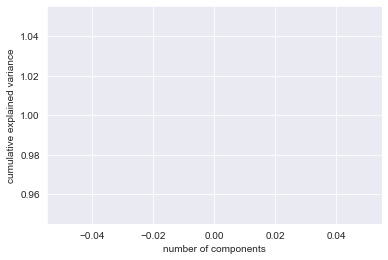

In [27]:
pca = PCA(n_components=0.95).fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [28]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [29]:
X_train_pca

array([[ 0.84725638],
       [-0.09808403],
       [ 0.12007145],
       ...,
       [ 1.28356734],
       [-1.62517239],
       [-0.02536554]])

LDA

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

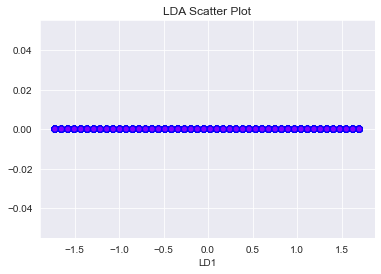

In [31]:
# Create a scatter plot of the transformed data
plt.scatter(X_train_lda, np.zeros(len(X_train_lda)), c=y_train, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.xlabel('LD1')
plt.title('LDA Scatter Plot')
plt.show()

In [32]:
X_train_preprocessed = X_train
X_test_preprocessed = X_test

Classification models

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model_name, y_true, y_pred):
    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(model_name)
    # Print the evaluation metrics
    print("Accuracy:", round(accuracy, 2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1-score:", round(f1, 2))
    print("ROC-AUC score:", round(roc_auc, 2))

    # Compute the confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Create a heatmap visualization of the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", ax=ax)

    # Set the axis labels and title
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")

    # Show the plot
    plt.show()

Logistic Regression model

In [34]:
# from sklearn.linear_model import LogisticRegression
# 
# # Define the range of values for each hyperparameter
# C = np.linspace(0.01, 1, 15)
# PENALTY = ['l1', 'l2']
# SOLVER = ['liblinear', 'saga']
# 
# PARAM_GRID  = {
#     'C': C,
#     'penalty': PENALTY,
#     'solver': SOLVER
# }
# 
# # Create the logistic regression estimator
# estimator = LogisticRegression(random_state=420)
# 
# # Use grid search and cross-validation to tune the hyper parameters
# model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
# model_searcher.fit(X_train_preprocessed, y_train)
# 
# # The best combination of hyperparameters
# model_searcher.best_params_

In [35]:
# # Get the best estimator
# log_reg_best_estimator = model_searcher.best_estimator_
# y_test_pred = log_reg_best_estimator.predict(X_test_preprocessed)
# 
# evaluate_model("Logistic Regression (test data)", y_test, y_test_pred) 

Gradient Boosting model

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the range of values for each hyperparameter
LEARNING_RATE = np.linspace(0.01, 0.5, 10)
MAX_DEPTH = range(2, 5)
N_ESTIMATORS = range(100, 180, 15)


PARAM_GRID  = {
    'learning_rate': LEARNING_RATE,
    'max_depth': MAX_DEPTH,
    'n_estimators': N_ESTIMATORS
}

# Create the gradient boosting estimator
estimator = GradientBoostingClassifier(random_state=420)

# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

{'learning_rate': 0.17333333333333334, 'max_depth': 2, 'n_estimators': 175}

Gradient Boosting (test data)
Accuracy: 0.46
Precision: 0.49
Recall: 0.52
F1-score: 0.5
ROC-AUC score: 0.45


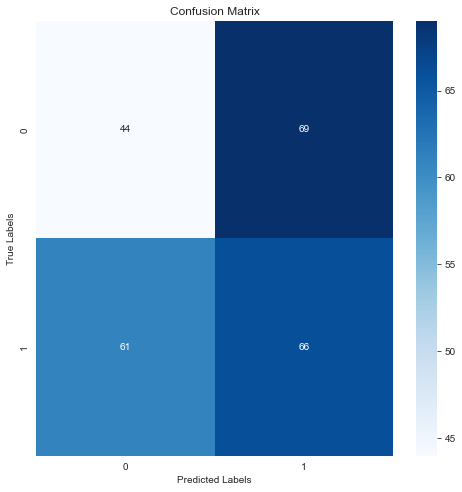

In [37]:
# Get the best estimator
gb_best_estimator = model_searcher.best_estimator_
y_test_pred = gb_best_estimator.predict(X_test_preprocessed)

evaluate_model("Gradient Boosting (test data)", y_test, y_test_pred)

Support Vector Machine model

In [ ]:
from sklearn.svm import SVC

# Define the range of values for each hyperparameter
C = np.linspace(0.01, 1, 15)
KERNEL = ['linear', 'poly', 'rbf', 'sigmoid']
GAMMA = ['scale', 'auto']

PARAM_GRID  = {
    'C': C,
    'kernel': KERNEL,
    'gamma': GAMMA
}

# Create the support vector machine estimator
estimator = SVC(random_state=420)

# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

Evaluate the best model on the test data

In [ ]:
svm_best_estimator = model_searcher.best_estimator_
y_test_pred = svm_best_estimator.predict(X_test_preprocessed)

evaluate_model("Support Vector Machine (test data)", y_test, y_test_pred)

Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the range of values for each hyperparameter
N_ESTIMATORS = range(50, 140, 15)
MAX_DEPTH = range(2, 6)
MIN_SAMPLES_SPLIT = range(2, 4)
MIN_SAMPLES_LEAF = range(1, 4)

PARAM_GRID  = {
    'n_estimators': N_ESTIMATORS,
    'max_depth': MAX_DEPTH,
    'min_samples_split': MIN_SAMPLES_SPLIT,
    'min_samples_leaf': MIN_SAMPLES_LEAF
}

# Create the random forest estimator
estimator = RandomForestClassifier(random_state=420)

# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)


# The best combination of hyperparameters
model_searcher.best_params_

In [ ]:
rf_best_estimator = model_searcher.best_estimator_
y_test_pred = rf_best_estimator.predict(X_test_preprocessed)

evaluate_model("Random Forest (test data)", y_test, y_test_pred)

XGBoost model

In [ ]:
from xgboost import XGBClassifier

# Define the range of values for each hyperparameter
LEARNING_RATE = np.linspace(0.05, 0.5, 10)
MAX_DEPTH = range(1, 5)
N_ESTIMATORS = range(70, 150, 15)

PARAM_GRID  = {
    'learning_rate': LEARNING_RATE,
    'max_depth': MAX_DEPTH,
    'n_estimators': N_ESTIMATORS
}

# Define the ratio for scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Create a XGBoost classifier with specific parameters
estimator = XGBClassifier(objective='binary:logistic', scale_pos_weight=ratio)


# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

Evaluate the best model on the test data

In [ ]:
xgb_best_estimator = model_searcher.best_estimator_
y_test_pred = xgb_best_estimator.predict(X_test_preprocessed)

evaluate_model("XGBoost (test data)", y_test, y_test_pred)

TabNetClassifier with automatic hyperparameters tuning

In [ ]:
!pip install pytorch-tabnet
!pip install optuna

In [ ]:
# Convert Pandas DataFrame to NumPy array
X_train_np = X_train_preprocessed.values
X_test_np = X_test_preprocessed.values

In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna
from sklearn.metrics import mean_squared_error

# Define objective function for optuna
def objective(trial):
    # Generate hyperparameter search space
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_a': trial.suggest_int('n_a', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 1, 19),
        'gamma': trial.suggest_float('gamma', 0.1, 2.0),
        'n_independent': trial.suggest_int('n_independent', 1, 10),
        'n_shared': trial.suggest_int('n_shared', 1, 10),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 0.0001, 0.1),
        # 'optimizer_fn': torch.optim.Adam,
        # 'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
        # 'mask_type': 'entmax',
        # 'scheduler_params': dict(mode="min", patience=5, min_lr=1e-5, factor=0.9,),
        # 'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
        'verbose': 0
    }

    # Create TabNetClassifier object with hyperparameters from optuna
    classifier = TabNetClassifier(**params)

    # Train and evaluate the model
    classifier.fit(X_train_np, y_train, eval_set=[(X_test_np, y_test)])
    val_preds = classifier.predict_proba(X_test_np)[:, 1]
    val_auc = roc_auc_score(y_test, val_preds)

    return val_auc

# Create optuna study
study = optuna.create_study(direction='maximize')

# Optimize hyperparameters using optuna
study.optimize(objective, n_trials=42, timeout=600)

# Get best hyperparameters from optuna
best_params = study.best_trial.params

# Train final model with best hyperparameters
tabnet = TabNetClassifier(**best_params)
tabnet.fit(X_train_np, y_train)
best_params

Evaluate the best model on the test data

In [ ]:
# Evaluate final model on test set
y_test_pred = tabnet.predict(X_test_np)
evaluate_model("Tabnet (test data)", y_test, y_test_pred)

The best model is Gradient Boosting

In [ ]:
the_best_model_ever = gb_best_estimator

Feature importance

In [ ]:
feature_importances = pd.DataFrame(the_best_model_ever.feature_importances_,
                                   index = X_train_preprocessed.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

Save the best model

In [ ]:
import pickle

# Save the best model
with open(os.path.join(config.classification_resource_dir, 'the_best_model_ever.pkl'), 'wb') as f:
    pickle.dump(the_best_model_ever, f)

In [ ]:
import pickle

# Load the best model
with open(os.path.join(config.classification_resource_dir, 'the_best_model_ever.pkl'), 'rb') as f:
    the_saved_model = pickle.load(f)

Decision Tree model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define the range of values for each hyperparameter
MAX_DEPTH = range(1, 3)
MIN_SAMPLES_SPLIT = range(2, 4)
MIN_SAMPLES_LEAF = range(1, 4)

PARAM_GRID  = {
    'max_depth': MAX_DEPTH,
    'min_samples_split': MIN_SAMPLES_SPLIT,
    'min_samples_leaf': MIN_SAMPLES_LEAF
}

# Create the decision tree estimator
estimator = DecisionTreeClassifier(random_state=420)

# Use grid search and cross-validation to tune the hyper parameters
model_searcher = GridSearchCV(estimator, PARAM_GRID, verbose=0)
model_searcher.fit(X_train_preprocessed, y_train)

# The best combination of hyperparameters
model_searcher.best_params_

In [ ]:
dt_best_estimator = model_searcher.best_estimator_
y_test_pred = dt_best_estimator.predict(X_test_preprocessed)

evaluate_model("Decision Tree (test data)", y_test, y_test_pred)

Visualize the DecisionTreeClassifier

In [ ]:
from sklearn.tree import plot_tree

# Plot the first tree
plt.figure(figsize=(20, 20))
plot_tree(dt_best_estimator, feature_names=X_train_preprocessed.columns, filled=True, rounded=True, fontsize=14)

# Save the tree as png file
plt.savefig('plot_tree.png')

# Show the plot
plt.show()

Plot Decision Tree with Graphviz

In [ ]:
from sklearn.tree import export_graphviz
import pydot

# Export the decision tree as a dot file
export_graphviz(dt_best_estimator, out_file='decision_tree.dot', feature_names=X_train_preprocessed.columns, rounded=True, precision=1, filled=True, class_names=['0', '1'])

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('decision_tree.dot')

# Write graph to a png file
graph.write_png('decision_tree.png')

# Display the tree
from IPython.display import Image
Image(filename='decision_tree.png')

Print Text Representation

In [ ]:
from sklearn.tree import export_text

# Print the text representation of the decision tree
print(export_text(dt_best_estimator, feature_names=list(X_train_preprocessed.columns)))

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

Explore the best features

In [ ]:
# Get the indices of the top 10 features
top10_idx = feature_importances.head(1).index
print(top10_idx)

# Subset the data based on the top 10 features
X_train_top10 = X_train_preprocessed[top10_idx]
X_test_top10 = X_test_preprocessed[top10_idx]

# Train the model on the top 10 features
dt_best_estimator.fit(X_train_top10, y_train)

# Evaluate the model on the test data
y_test_pred = the_saved_model.predict(X_test_top10)
evaluate_model("Gradient Boosting (test data, top 10 features)", y_test, y_test_pred)

print(export_text(dt_best_estimator, feature_names=list(X_train_preprocessed[top10_idx].columns)))


In [ ]:
# plot the top 1 feature based on features_df and labels_df (mem) - to see the difference between the groups

In [ ]:
import seaborn as sns

# Get the index of the top 1 feature as string
top1_idx = str(feature_importances.head(1).index[0]) # 'Duration_Saccades_End_First_In_RoI_Pre' 
print(top1_idx)

# Subset the data based on the top 1 feature
data_df_top1 = features_df.merge(labels_df, left_index=True, right_index=True)[[top1_idx, 'mem']]
print(data_df_top1.head())

# Plot the top 1 feature in a swarmplot
plt.figure(figsize=(10, 10))
sns.swarmplot(x='mem', y=top1_idx, data=data_df_top1)
# sns.violinplot(x='mem', y=top1_idx, data=data_df_top1)
plt.title(top1_idx)
plt.show()

Plot both distributions side by side of the top 1 feature for the two groups

In [ ]:
plt.figure(figsize=(10, 10))
sns.distplot(data_df_top1[data_df_top1['mem'] == 0][top1_idx], hist=False, label='0')
sns.distplot(data_df_top1[data_df_top1['mem'] == 1][top1_idx], hist=False, label='1')
plt.title(top1_idx)
plt.show()